# A statistical analysis of stochastic gambling games
#### Project by Kári Hlynsson

We will be analysing stochastic gambling games and demonstrating some mathematical qualities of the concept commonly known as *gambler's ruin*, a term coined by Dutch mathematician Christiaan Huygens. The codebase used for this analysis is accessible on the [author's GitHub page](https://github.com/lvthnn/GamblersRuin). We start with the introduction of mathematical definitions and syntax to present the problem at hand.

I would like to refer you to article I made regarding this subject on my [website](https://lvthnn.github.io) where you can also fetch a PDF version.

## The gambling function, $G(t)$
Presume that a gambler plays $n$ games which have the same probability of success, denoted by $p$. The player possesses the initial capital $C_0$ which is subject to change according to the piecewise function $G(t)$ where $t \geq 0$ such that

$$
G(t) = \begin{cases} C_t + 1 &\text{if the player wins,} \\ C_t - 1 &\text{otherwise.}\end{cases}
$$

Entering some arbitrary $t$ into $G(t)$ thus yields the player's capital at $t + 1$. To start with the analysis, let's import the codebase we'll be using and some auxiliary packages:

In [1]:
from gamblersruin import GamblersRuin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

We want to set the seed for the Numpy RNG engine for reproducible results:

In [ ]:
np.random.seed(42)

The `GamblersRuin` class is instantiated with the parameters `sim_duration`, `initial_capita` and `p`. The value assigned to `p` is used only when no `p_vec` parameter is supplied to the `simulate_game` method, i.e. the `p` value fed to the constructor is in a sense a "fallback value". Let's simulate 100 games which consist of 1000 gambles each with the default probability $0.5$.

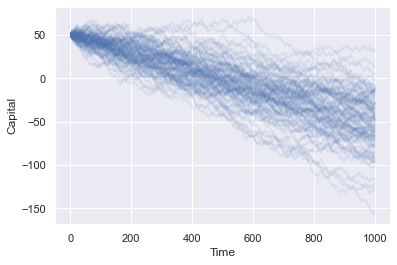

In [2]:
# Initialize gambler's ruin class and simulate games:
gr = GamblersRuin(sim_duration=1000, initial_capital=50, p=0.45)
games = gr.simulate_game(num_games=100)

# To visualize the game:
gr.visualize_games(games)

## Expected change per gamble, $\mathbb E[C_{t + 1}]$
In this section we go about understanding the expected trend of a stochastic gambling game given some value of $p$. Notice that the [expected value](https://en.wikipedia.org/wiki/Expected_value#Random_variables_with_finitely_many_outcomes) of a discrete random variable $X$ is given by

$$
\mathbb E[X] = \sum_{x \in \Omega} x \mathbb P\{X = x\}
$$

where $\Omega$ denotes the [sample space](https://en.wikipedia.org/wiki/Sample_space) of $X$. We can apply this to our stochastic games by noting that $\Omega = \{C_t + 1, C_t - 1\}$ to obtain that $\mathbb E[C_{t + 1}] = C_t + \xi$ where $\xi := 2p - 1$. (The proof to this statement can be viewed in its entire on the article I wrote for my webpage). Thus we expect the average change for a gamble to be positive only when $\xi > 0$, i.e. $p > 1/2$.

Let's turn back to the codebase. An additional parameter to the `visualize_games` method is `show_theoretical` which accepts a boolean input and draws the average trendline if instructed to do so. This can be done in the following way:

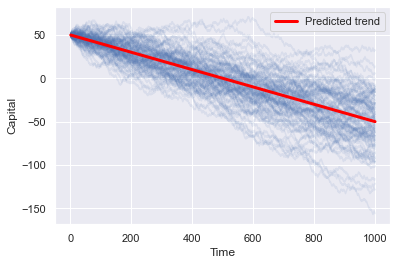

In [3]:
# We use the same object as before but this time show the theoretical trend.
gr.visualize_games(games, show_theoretical=True)

The `average_error` function allows us to calculate the deviation from the expected model for our simulated games. Notice that these deviations are normal!

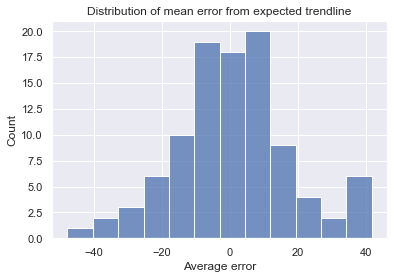

In [11]:
err = gr.average_error(games)
averages = [df["avg_error"][0] for df in err]

sns.histplot(x=averages)
plt.title("Distribution of mean error from expected trendline")
plt.xlabel("Average error")
plt.show()

## Applications of survival analysis
In short, survival analysis is the probabilistic study of the likelihood of an *event* after a given period oftime has passed. To read more on the fundamental aspects of this field, [follow this link](https://en.wikipedia.org/wiki/Survival_analysis).

### The Kaplan-Meier estimator
We can apply the Kaplan-Meier estimator for approximating survival functions with different values of $p$. This has been implemented by the `survival_analysis` method which accepts a vector of games as input and draws a plot of the Kaplan-Meier estimator. Let us perform survival analysis for varying levels of $p$: $0.425, 0.450, 0.475$ and $0.500$.

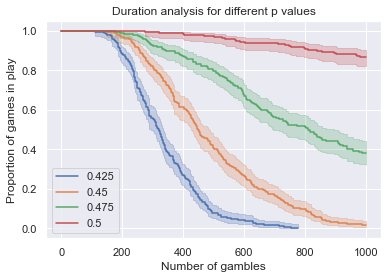

In [12]:
p_values = [0.425, 0.450, 0.475, 0.500]
surv_games = gr.simulate_game(1000, p_values)  # Simulates 250 games per p-value

gr.survival_analysis(surv_games)

### Median of survival
The median of survival is defined as the argument $t^*$ to the survival function $S$ such that $S(t^*) = 0.5$. We can use the `median_survival` method on our `games` object from the previous codeblock to obtained structured data on the medians of survivals for these games:

In [6]:
many_p_values = np.linspace(0.4, 0.5, 1000)
many_p_games = gr.simulate_game(10000, many_p_values)

median_over_p = gr.median_survival(many_p_games)

And to trim our data a little bit:

In [7]:
median_over_p.replace([np.inf, -np.inf], np.nan, inplace=True)
median_over_p.dropna(inplace=True)

A value of `inf` in the median column denotes that the survival function for the $p$ value in question does not drop below $0.5$ in the given time period. We can clearly see that this is the case for $p = 0.5$ when $t_\max = 1000$ (at least in this simulation). Let's plot the median of survival as a function of the $p$ value:

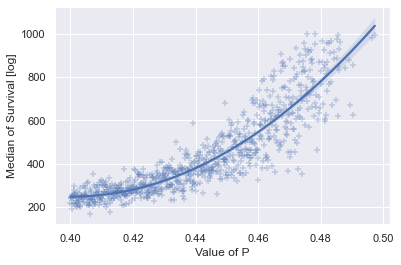

In [13]:
ax = plt.subplot()
sns.regplot(x="p", y="median", data=median_over_p, ax=ax, marker="+",
            scatter_kws={"alpha":0.3}, order=2)
plt.xlabel("Value of P")
plt.ylabel("Median of Survival [log]")
plt.show()